In [18]:
import glob,os
import numpy as np
import pandas as pd
import re

# import astropy
import GCRCatalogs as gcr
from astropy.table import Table, setdiff, vstack

import matplotlib.pyplot as plt
plt.style.use('MNRAS.mplstyle')

h = 0.71
filepath = r"/global/u1/k/kamau/SE-CLMM-LSSTDESC/project-1/Data/"
file_path = r'/global/u1/k/kamau/SE-CLMM-LSSTDESC/project-1/Notebooks/skysim5000/Depth/calc-richness/DepthData/'

# Load the cylinder richness data of the different depths

In [20]:
def load_and_process_data(filepath, depth):
    filename = f"RichnessDepth-Data/RichnessDepth_{depth}_02_035.dat"
    data_unsorted = Table.read(filepath + filename, format='ascii')
    
    data_sorted = Table(np.sort(data_unsorted, order='lam'))[::-1]
    print(f'D{depth}' ,len(data_sorted), len(np.unique(data_sorted['pixelid'])))
    
    return data_sorted

# Load and process richness data for different depths
cluster_1 = load_and_process_data(file_path, 1)
cluster_30 = load_and_process_data(file_path, 30)
cluster_60 = load_and_process_data(file_path, 60)
cluster_90 = load_and_process_data(file_path, 90)
cluster_120 = load_and_process_data(file_path, 120)

D1 146936 1568
D30 152268 1568
D60 150944 1568
D90 150011 1568
D120 149357 1568


# Load cluster-halos matched (RedMaPPer)

In [21]:
cluster_halos_red = pd.read_pickle(filepath + 'halos/halos_redmapper_withh_mthd2.csv')
print(len(cluster_halos_red))
cluster_halos_red = cluster_halos_red[(cluster_halos_red['redshift']>=0.2) & (cluster_halos_red['redshift']<0.35)]
cluster_halos_red = cluster_halos_red.sort_values(by='richness',ascending=False)
print(len(cluster_halos_red))

lamranges = [(20,30), (30,45), (45,60), (60,500)]
lamlabels = ['(20,30]', '(30,45]', '(45,60]', '(60,500]']
cluster_halos_red['lambda_range'] = pd.cut(cluster_halos_red['richness'], bins=[r[0] for r in lamranges] + [lamranges[-1][-1]], labels=lamlabels)
grouped_cl_halos_red = cluster_halos_red.groupby(['lambda_range'])

cluster_halos_red[:5]

37798
4683


,cluster_id,richness,dec,redshift_1,clusters/z_lambda,clusters/mem_match_id,ra,halo_id,baseDC2/sod_halo_mass,halo_mass,redshift,baseDC2/sod_halo_radius,pixel_id,comoving_dis,Angular_dis,radius,sigma,DS,lambda_range
10937,2,410.424042,-31.395138,0.268949,0.268949,2,82.058229,333509309392,7.278854e+14,2.103824e+15,0.269587,1.690038,9309,762.526080,600.609347,"[0.12371025309249428, 0.21778958319077213, 0.3...","[1231843818024732.2, 605919391086219.0, 434794...","[-312694676717985.9, -469850190862547.6, -3249...","(60,500]"
15786,26,278.834625,-44.258323,0.321668,0.321668,26,37.670702,521210440373,1.059300e+15,1.620128e+15,0.325387,1.969504,10440,908.482367,685.446662,"[0.14126705534123202, 0.18844889681180063, 0.3...","[1435321585310083.0, 1181425216996936.5, 67592...","[171701809615776.66, -440574012028238.06, -420...","(60,500]"
9838,12,276.424347,-54.813579,0.240101,0.240101,12,10.735896,297311186401,6.909374e+14,1.474827e+15,0.246225,1.636741,11186,700.187568,561.846665,"[0.12997294539087412, 0.2115441528069944, 0.31...","[1232029916201197.5, 484838812804278.8, 378995...","[-656473315891683.4, -436391272991250.7, -3307...","(60,500]"
5183,18,268.156158,-15.572900,0.318540,0.318540,18,56.205198,152507764373,1.099301e+15,1.876986e+15,0.315978,1.993995,7764,884.160742,671.865897,"[0.13503442657590373, 0.19488453228804448, 0.3...","[1869687348117492.2, 1418076870585712.2, 75036...","[-609252390827244.9, -724482293908036.5, -5004...","(60,500]"
6413,43,249.667130,-4.504308,0.289632,0.289632,43,60.858457,190406613382,7.617416e+14,1.823229e+15,0.296747,1.739102,6613,834.084555,643.213163,"[0.13727150206013278, 0.1996564096015648, 0.32...","[1004800191888836.4, 956284433436844.9, 486264...","[3189431113003.2935, -237956414772056.47, -252...","(60,500]"


# Load redmapper clusters

In [60]:
redmapper = gcr.load_catalog('skysim5000_v1.1.1_redmapper_v0.8.5')
redmapper_cl = Table(redmapper.get_quantities(['cluster_id','ra','dec','redshift','richness','clusters/z_lambda','clusters/mem_match_id'])) #46491
# redmapper_me = Table(redmapper.get_quantities(['cluster_id_member','dec_member','ra_member','p_member'])) #2381320
print(len(redmapper_cl))

46491


# Load Halos data with Weak lensing profiles

In [22]:
## Sigma and DS profile
sigma_ds_profile = pd.read_pickle(filepath + 'WL-Signal/skysim-full-DS_S-2152757.csv')
print(len(sigma_ds_profile))

2152757


# Merge halos with clusters @ 30

In [68]:
# List of cluster tables and suffix values
# cluster_1 = cluster_1.to_pandas()
# cluster_30 = cluster_30.to_pandas()
# cluster_60 = cluster_60.to_pandas()
# cluster_90 = cluster_90.to_pandas()
# cluster_120 = cluster_120.to_pandas()

cluster_tables = [cluster_1, cluster_30, cluster_60, cluster_90, cluster_120] #, cluster_30, cluster_60, cluster_90, cluster_120
suffix_values = [1, 30, 60, 90, 120]

# Dictionary to store the halo tables dynamically
halo_cluster_tables = {}

# Iterate over the tables and suffix values
for i, (cluster_table, suffix) in enumerate(zip(cluster_tables, suffix_values), 1):
    halo_table_name = f"cluster_halo_{suffix}"

    # Perform the join and other operations
    halo_table = pd.merge(sigma_ds_profile,cluster_table, left_on='halo_id',right_on='haloid', how='inner').sort_values(by='lam', ascending=False)
    halo_cluster_tables[halo_table_name] = halo_table
    print(f"Length of {halo_table_name}: {len(halo_table)}")

cluster_halo_1 = halo_cluster_tables['cluster_halo_1']
cluster_halo_30 = halo_cluster_tables['cluster_halo_30']
cluster_halo_60 = halo_cluster_tables['cluster_halo_60']
cluster_halo_90 = halo_cluster_tables['cluster_halo_90']
cluster_halo_120 = halo_cluster_tables['cluster_halo_120']

Length of cluster_halo_1: 146936
Length of cluster_halo_30: 152268
Length of cluster_halo_60: 150944
Length of cluster_halo_90: 150011
Length of cluster_halo_120: 149357


In [69]:
# sel_clusters = grouped_cl_halos_60.get_group('(60,500]') #[:len(sel_clusters_red)]
# sel_clusters = sel_clusters.sort_values(by='lam', ascending=False)[:len(sel_clusters)]

# red = grouped_cl_halos_red.get_group('(60,500]') #[:len(sel_clusters_red)]
# red = red.sort_values(by='richness', ascending=False)[:len(red)]

# sel_clusters['lam'], red['richness']

# len(cluster_halo_120[cluster_halo_120['lam']>20]), len(cluster_halo_60)
# cluster_halo_30['lambda_range'].value_counts()

In [70]:
## Weighted Profile
def stacked_profile_weighted_by_mass_redshift(lnM_select, z_select, prof_select, lnM_all, z_all, profile_A, dm=0.1, dz=0.05):
    #### set up the bins for mass and redshift  (sigma_select/profile_select, sigma_all/profile_all)
    min_m = min(lnM_select)#-dm
    max_m = max(lnM_select)#+dm
    min_z = min(z_select)#-dz
    max_z = max(z_select)#+dz

    # print('z', min_z, max_z)
    m_bins = np.arange(min_m, max_m+dm, dm)
    z_bins = np.arange(min_z, max_z+dz, dz)
    nM = len(m_bins)-1
    nz = len(z_bins)-1
    # print('nM, nz', nM, nz)

    profile_select = np.array([i.tolist() for i in prof_select])
    profile_all = np.array([i.tolist() for i in profile_A])

    nr = np.shape(profile_select)[1]#rbp.nbins_phys_mpc...1
    profile_weighted = np.zeros(nr)
    weight_norm = 0


    pdf1_list = np.zeros([nz, nM]) # see how many bins are too narrow
    pdf2_list = np.zeros([nz, nM]) # see how many bins are too narrow

    for iz in range(nz):
        z_lo = z_bins[iz]
        z_hi = z_bins[iz+1]
        # print(z_lo,z_hi)
        for iM in range(nM):
            m_lo = m_bins[iM]
            m_hi = m_bins[iM+1]
            # print(m_lo, m_hi)
            
            select_bin = (lnM_select >= m_lo)&(lnM_select < m_hi)&(z_select>=z_lo)&(z_select<z_hi)
            weight = len(lnM_select[select_bin]) * 1.
            # print(weight, len(lnM_select[select_bin]),lnM_select[select_bin])
            weight_norm += weight
            # print(weight_norm)
            select_all = (lnM_all >= m_lo)&(lnM_all < m_hi)&(z_all>=z_lo)&(z_all<z_hi)

            pdf1_list[iz, iM] = weight
            # print(pdf1_list)
            pdf2_list[iz, iM] = len(lnM_all[select_all])
            # print(pdf2_list)

            if weight > 0 and len(lnM_all[select_all]) > 0:
                # print(weight, len(lnM_all[select_all]))
                # if weight == len(lnM_all[select_all]):
                    # print('bin is too narrow!')
                profile_weighted += (np.mean(profile_all[select_all, :], axis=0)*weight) #0
                #profile_weighted += np.nan_to_num(np.mean(profile_all[select_all, :], axis=0)*weight)
            #profile_weighted = np.nan_to_num(profile_weighted)
    profile_weighted /= weight_norm

    pdf1_list = np.concatenate(pdf1_list)
    pdf2_list = np.concatenate(pdf2_list)
    diff_list = pdf2_list - pdf1_list
    # print('pdf1==pdf2', len(diff_list[diff_list == 0]), 'out of', len(diff_list))

    return profile_weighted

/global/homes/k/kamau/clmmdesc/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


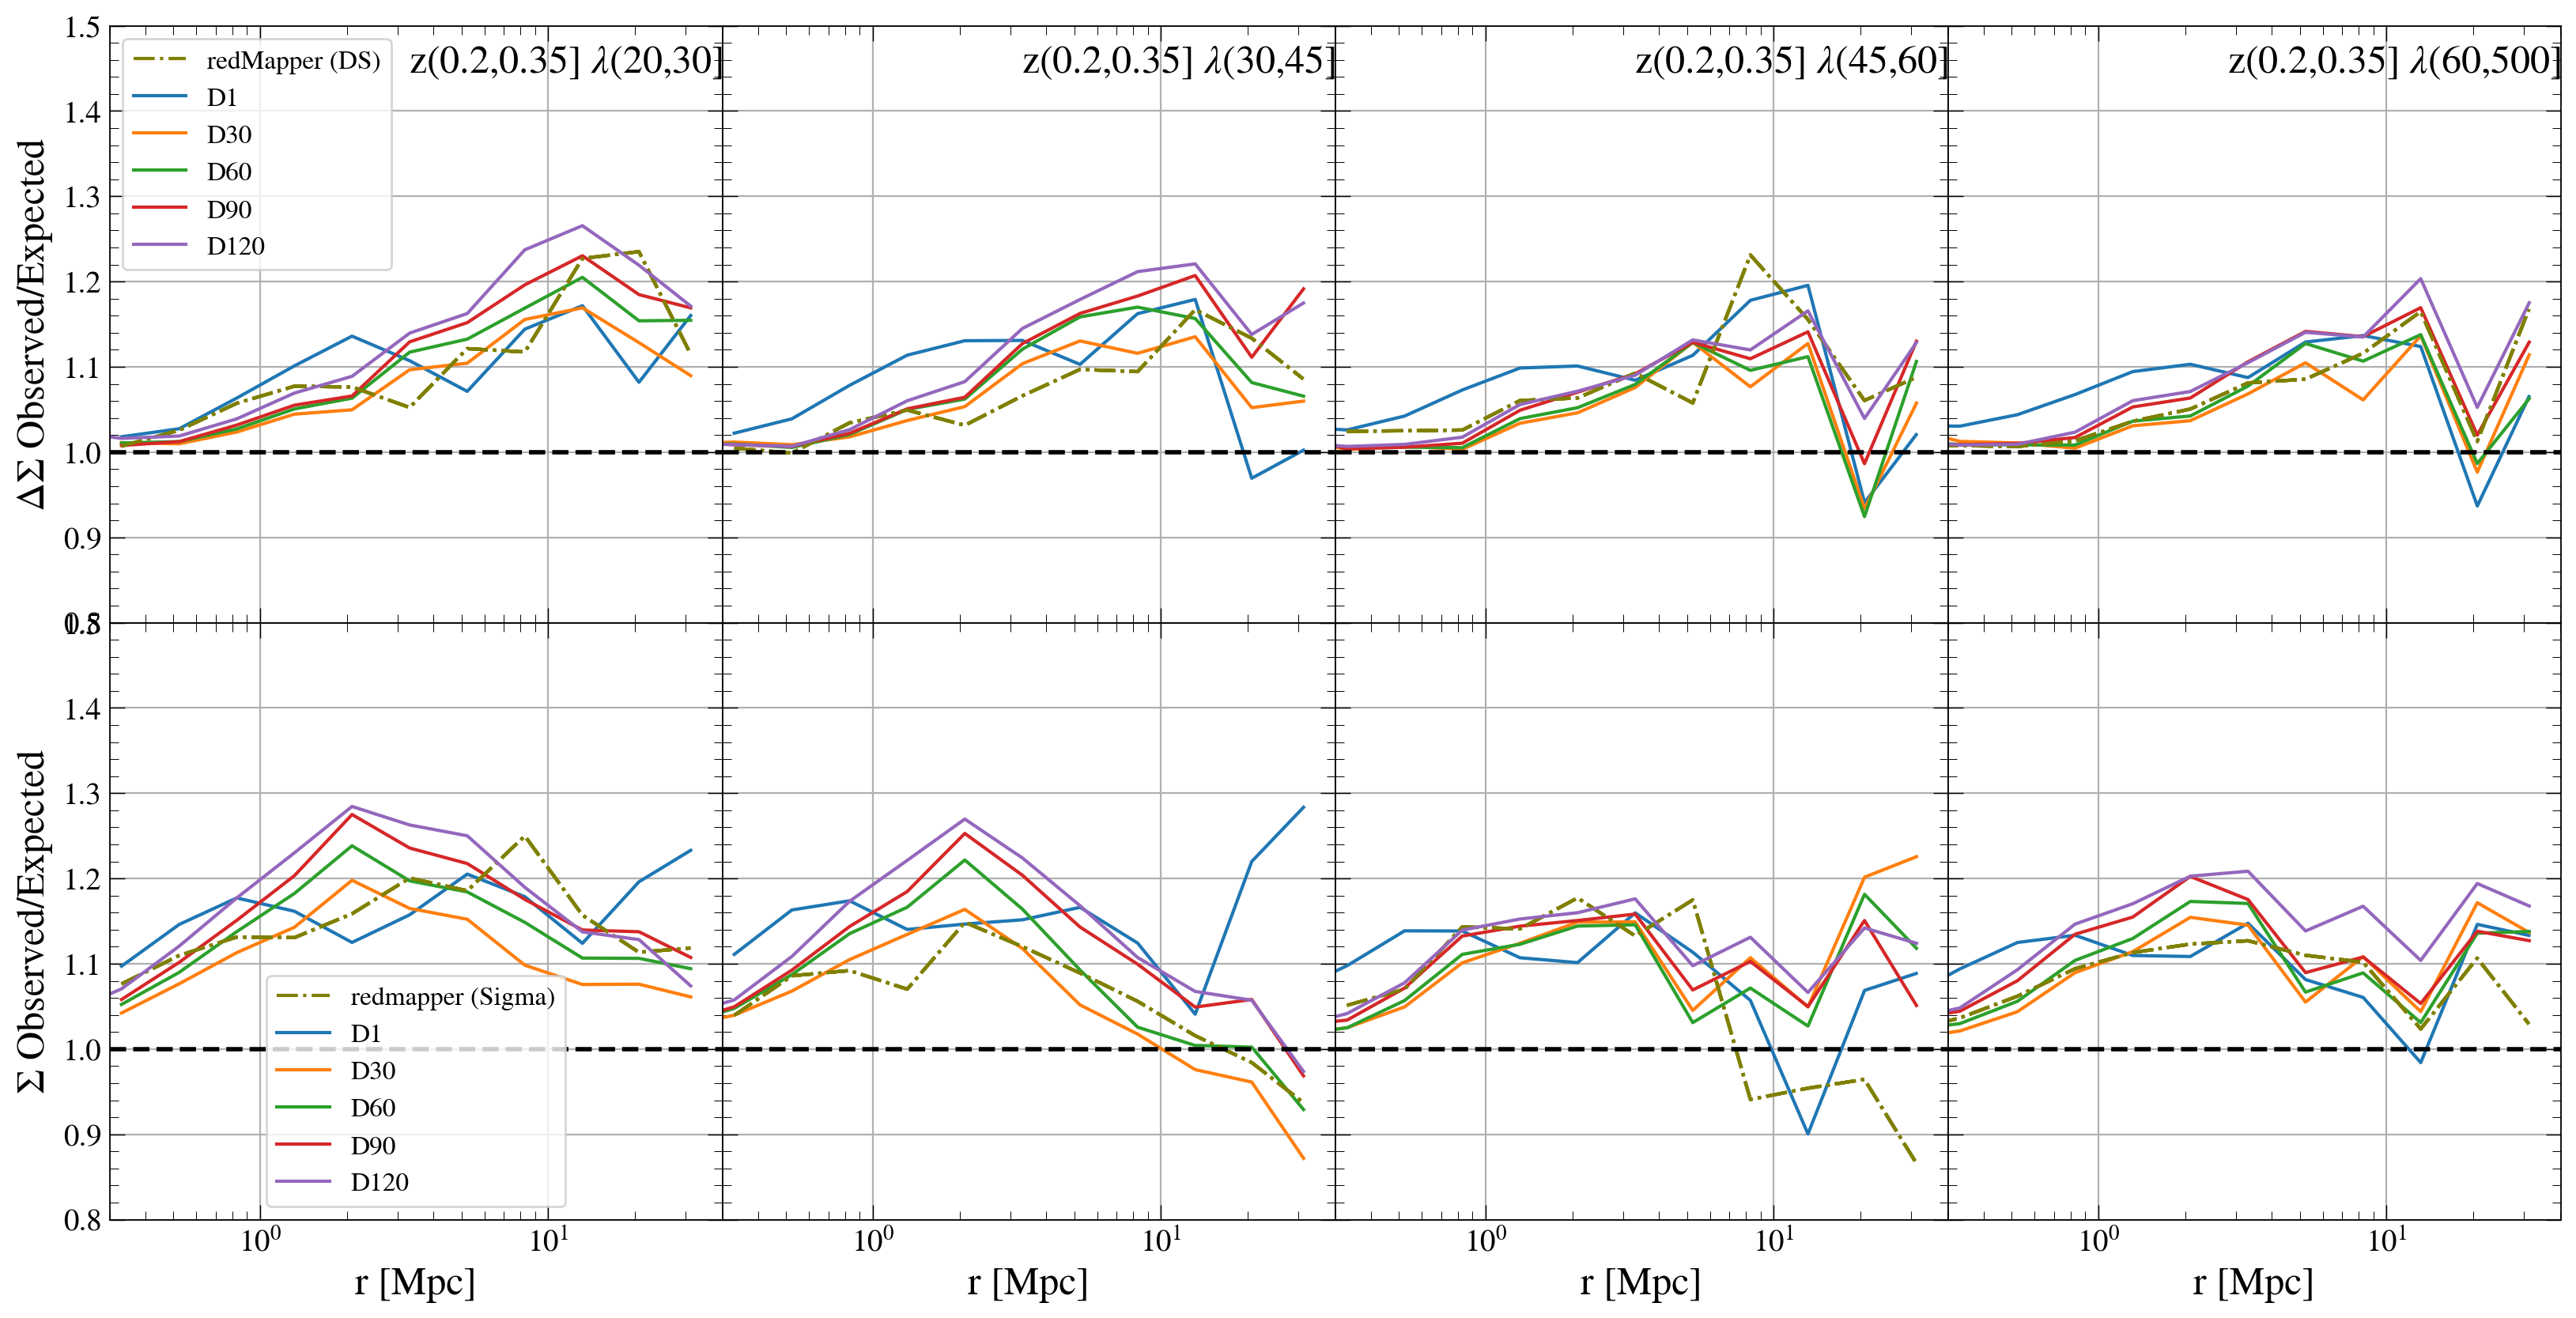

In [71]:
underlying_halos = sigma_ds_profile[(sigma_ds_profile['redshift'] >= 0.2) & (sigma_ds_profile['redshift'] < 0.35)]
lnM_All = np.log10(underlying_halos['baseDC2/sod_halo_mass'])
z_All = underlying_halos['redshift']
profile_All = underlying_halos['sigma']
profile_All_ds = underlying_halos['DS']

# Function to select clusters based on lambda values and calculate ratios
def select_and_calculate_ratios(cluster_halo, num_clusters_in_bin, lnM_All, z_All, profile_All_ds, profile_All):
    sel_clusters = cluster_halo.nlargest(num_clusters_in_bin, 'lam')
    cluster_halo = cluster_halo.drop(sel_clusters.index)
    lnM_sel = np.log10(sel_clusters['baseDC2/sod_halo_mass'])
    z_sel = sel_clusters['redshift_y']
    profile_sel = sel_clusters['sigma']
    profile_sel_ds = sel_clusters['DS']

    expected_ds = stacked_profile_weighted_by_mass_redshift(lnM_sel, z_sel, profile_sel_ds, lnM_All, z_All, profile_All_ds)
    expected_sigma = stacked_profile_weighted_by_mass_redshift(lnM_sel, z_sel, profile_sel, lnM_All, z_All, profile_All)

    ratio_ds = np.array(profile_sel_ds.mean(axis=0)) / np.array(expected_ds)
    ratio_sigma = np.array(profile_sel.mean(axis=0)) / np.array(expected_sigma)
    radius = sel_clusters['radius'].mean()
    return radius, ratio_ds, ratio_sigma

# Create a figure with subplots
fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharex=True, sharey=True)
D = [1, 30, 60, 90, 120]


for lambda_group in sorted(grouped_cl_halos_red.groups.keys(), reverse=True):
    sel_clusters_red = grouped_cl_halos_red.get_group(lambda_group)
    lnM_sel_red = np.log10(sel_clusters_red['baseDC2/sod_halo_mass'])
    z_sel_red = sel_clusters_red['redshift']
    profile_sel_red = sel_clusters_red['sigma']
    profile_sel_ds_red = sel_clusters_red['DS']
    
    
    num_clusters_in_bin = len(sel_clusters_red)
    
    expected_ds_red = stacked_profile_weighted_by_mass_redshift(lnM_sel_red, z_sel_red, profile_sel_ds_red, lnM_All, z_All, profile_All_ds)
    expected_sigma_red = stacked_profile_weighted_by_mass_redshift(lnM_sel_red, z_sel_red, profile_sel_red, lnM_All, z_All, profile_All)

    ratio_ds_red = np.array(profile_sel_ds_red.mean(axis=0)) / np.array(expected_ds_red)
    ratio_sigma_red = np.array(profile_sel_red.mean(axis=0)) / np.array(expected_sigma_red)
    
    lambda_value = float(re.findall(r'\d+', lambda_group)[0])
    
    # Iterate over different cluster_halo datasets
    for i, cluster_halo in enumerate([ cluster_halo_1,cluster_halo_30, cluster_halo_60, cluster_halo_90, cluster_halo_120]): #cluster_halo_30, cluster_halo_60, cluster_halo_90, cluster_halo_120
        radius, ratio_ds, ratio_sigma = select_and_calculate_ratios(cluster_halo, num_clusters_in_bin, lnM_All, z_All, profile_All_ds, profile_All)

        # Plotting
        col_index = int(lambda_value) // 15 - 1

        axes[0, col_index].plot(sel_clusters_red['radius'].mean(), ratio_ds_red, label='redMapper (DS)' if i == 0 else None, linestyle='dashdot',color='olive')
        axes[0, col_index].plot(radius, ratio_ds, label=f'D{D[i]}')
        axes[0, col_index].set_ylim([0.5, 2])
        
        axes[1, col_index].plot(sel_clusters_red['radius'].mean(), ratio_sigma_red, label='redmapper (Sigma)' if i == 0 else None, linestyle='dashdot',color='olive')
        axes[1, col_index].plot(radius, ratio_sigma, label=f'D{D[i]}')
        axes[1, col_index].set_ylim([0.8, 1.5])
                                    
    # Set plot properties
    for row_index, ax_row in enumerate(axes):
        ax_row[col_index].set_xscale('log')
        ax_row[col_index].set_ylabel('$\Delta\Sigma$ Observed/Expected' if row_index == 0 else '$\Sigma$ Observed/Expected', fontsize=18)
        ax_row[0].legend(loc='best', fontsize=12)
    # Set the title inside the subplot
    title = f'z(0.2,0.35] $\lambda${lambda_group}'
    title_y = 1.1 if row_index > 3 else 0.9  # Adjust the y position for the last row
    axes[0,col_index].set_title(title,  loc='right', y=title_y, fontsize=18)


# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0, wspace=0)

for ax in axes.flat:
    ax.label_outer()
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.axhline(y=1, color='black', linestyle='--', linewidth=2)

# Set the x and y-axis labels for the bottom subplots
for ax in axes[-1, :]:
    ax.set_xlabel('r [Mpc]', fontsize=18)

for ax in axes[1, :]:
    ax.set_xlim(0.3, None)

plt.show()


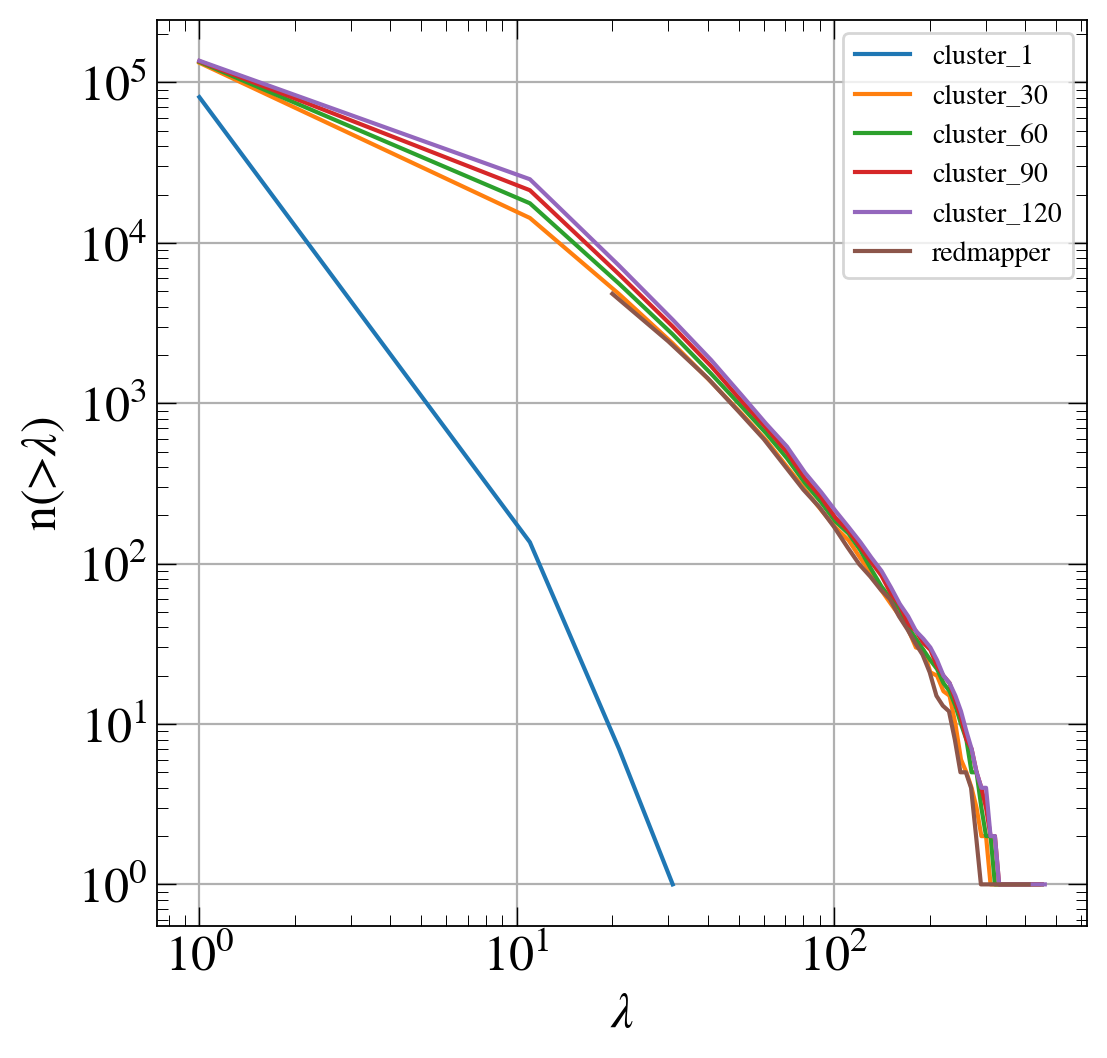

In [62]:
redmapper_cl = redmapper_cl[(redmapper_cl['redshift']>=0.2) & (redmapper_cl['redshift']<0.35)]

def n_greater_than_lambda(data):
    for i in range(len(data)):
        lambda_values = np.arange(data[i].min(), data[i].max(), 10)
#         print(lambda_values)
        n_greater_than_lambda = np.zeros(lambda_values.shape)
        for j in range(len(lambda_values)):
            n_greater_than_lambda[j] = np.count_nonzero(data[i] > lambda_values[j]) #/ len(data[i])
#         print(n_greater_than_lambda)
        plt.yscale('log')
        plt.xscale('log')
        plt.plot(lambda_values, n_greater_than_lambda, label=labels[i])

    plt.xlabel('$\lambda$')
    plt.ylabel('n(>$\lambda$)')
#     plt.xlim(20,None)
#     plt.ylim(None,4e3)
    plt.legend(fontsize=10)
    plt.show()

# Generate some data
data = [cluster_1['lam'],cluster_30['lam'],cluster_60['lam'],cluster_90['lam'],cluster_120['lam'],redmapper_cl['richness']] #cluster_30['lam'],cluster_60['lam'],cluster_90['lam'],cluster_120['lam'],
labels = ['cluster_1', 'cluster_30','cluster_60','cluster_90','cluster_120','redmapper'] 

n_greater_than_lambda(data)

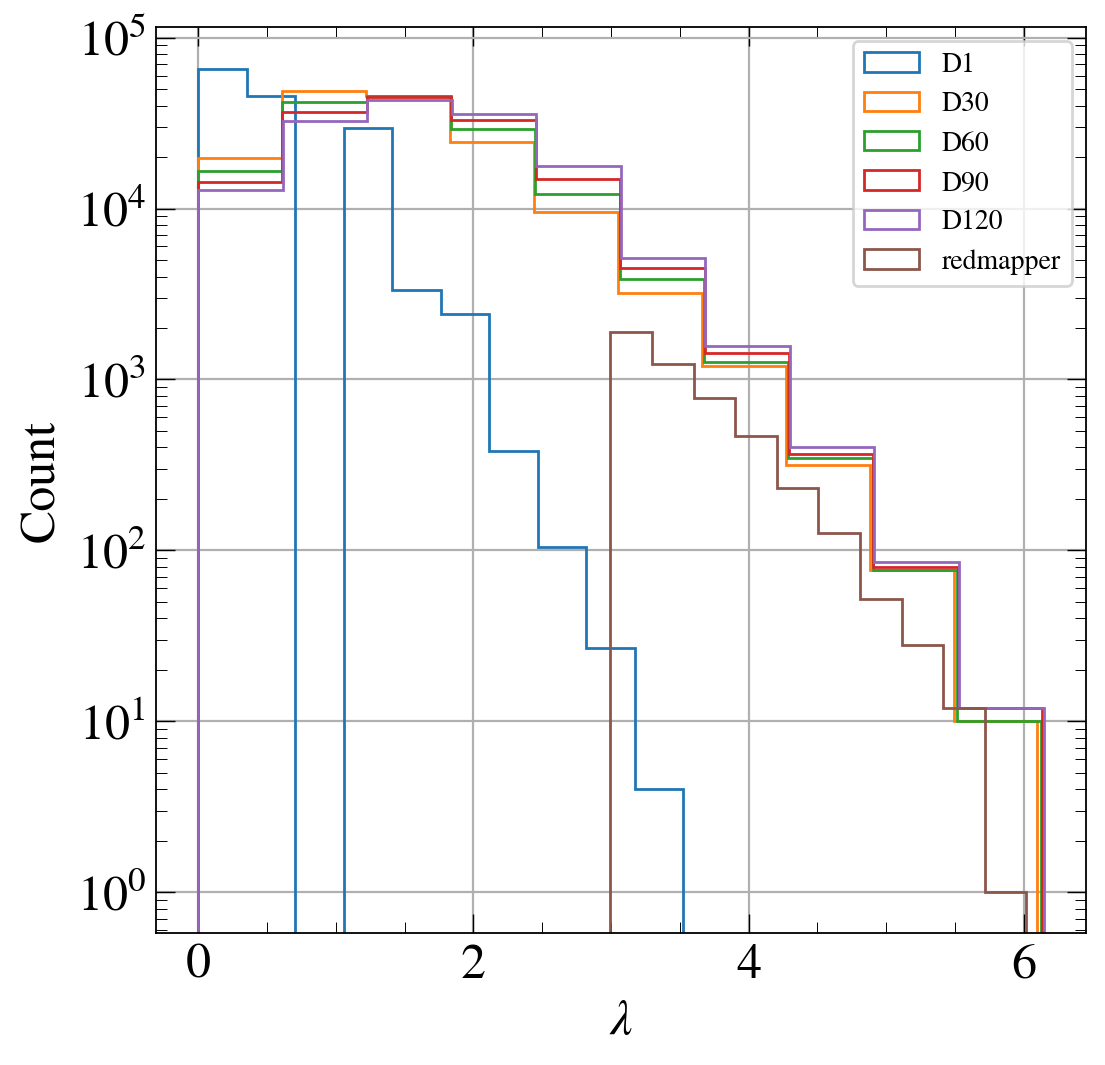

In [63]:
plt.hist(np.log(cluster_1['lam']), label='D1',  histtype='step')
plt.hist(np.log(cluster_30['lam']), label='D30', histtype='step')
plt.hist(np.log(cluster_60['lam']), label='D60', alpha=1, histtype='step')
plt.hist(np.log(cluster_90['lam']), label='D90',  histtype='step')
plt.hist(np.log(cluster_120['lam']), label='D120',  histtype='step')
plt.hist(np.log(redmapper_cl['richness']), label='redmapper',  histtype='step')

# plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\lambda$')  # Adjusted to put 'lam' on the x-axis
plt.ylabel('Count')
plt.legend(loc='best',fontsize=10)
plt.show()

# Debugging

104095 126319 125571 126459 125979
104095 126319 125571 126459 125979


/global/homes/k/kamau/clmmdesc/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
No handles with labels found to put in legend.
/global/homes/k/kamau/clmmdesc/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
No handles with labels found to put in legend.
/global/homes/k/kamau/clmmdesc/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
No handles with labels found to put in legend.
/global/homes/k/kamau/clmmdesc/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


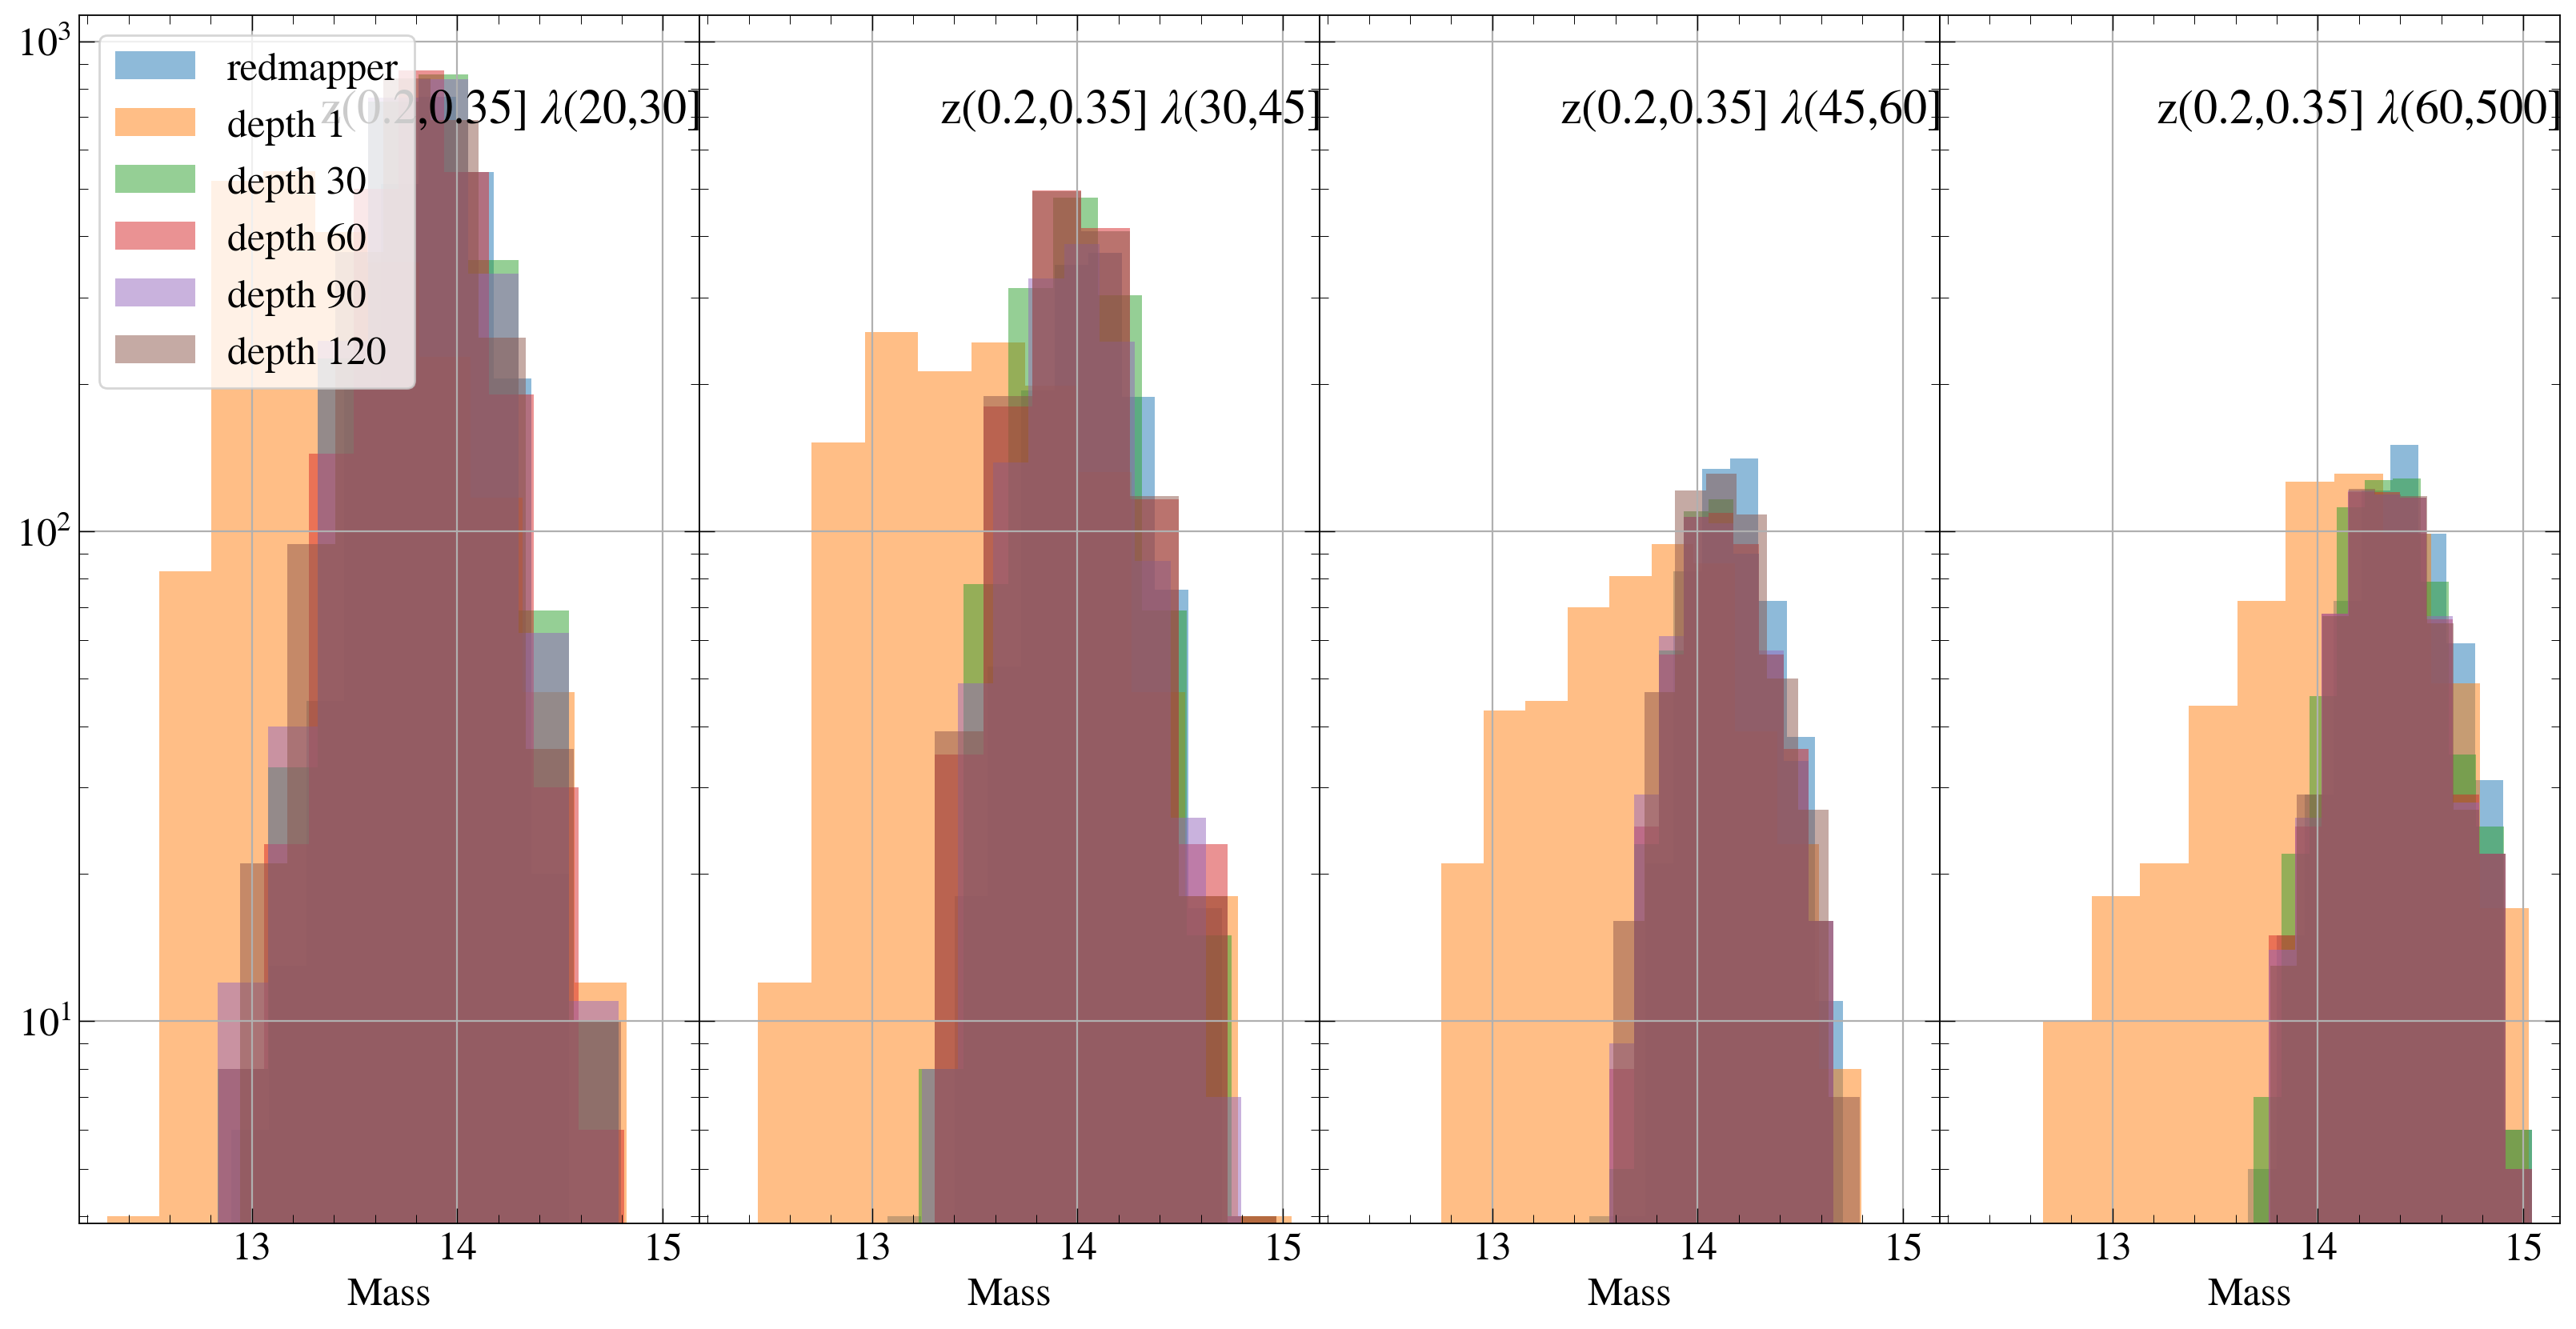

In [13]:
cluster_halo_1 = pd.merge(sigma_ds_profile,cluster_1, on='halo_id', how='inner').sort_values(by='lam', ascending=False)
cluster_halo_30 = pd.merge(sigma_ds_profile,cluster_30, on='halo_id', how='inner').sort_values(by='lam', ascending=False)
cluster_halo_60 = pd.merge(sigma_ds_profile,cluster_60, on='halo_id', how='inner').sort_values(by='lam', ascending=False)
cluster_halo_90 = pd.merge(sigma_ds_profile,cluster_90, on='halo_id', how='inner').sort_values(by='lam', ascending=False)
cluster_halo_120 = pd.merge(sigma_ds_profile,cluster_120, on='halo_id', how='inner').sort_values(by='lam', ascending=False)
print(len(cluster_halo_1), len(cluster_halo_30),len(cluster_halo_60),len(cluster_halo_90),len(cluster_halo_120))
print(len(cluster_1), len(cluster_30),len(cluster_60),len(cluster_90),len(cluster_120))


# Create a figure with subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 10), sharex=True, sharey=True)

for lambda_group in sorted(grouped_cl_halos_red.groups.keys(), reverse=True):
    sel_clusters_red = grouped_cl_halos_red.get_group(lambda_group)
    lnM_sel_red = np.log10(sel_clusters_red['baseDC2/sod_halo_mass'])
    z_sel_red = sel_clusters_red['redshift']
    profile_sel_red = sel_clusters_red['sigma']
    profile_sel_ds_red = sel_clusters_red['DS']

    num_clusters_in_bin = len(sel_clusters_red)
    
    sel_clusters_1 = cluster_halo_1.nlargest(num_clusters_in_bin, 'lam') # Select the top clusters from cluster_halo_30 based on halo_mass
    # sel_clusters_1 = sel_clusters_1[sel_clusters_1['baseDC2/sod_halo_mass']>0]
    cluster_halo_1 = cluster_halo_1.drop(sel_clusters_1.index) # Remove the selected clusters from cluster_halo_30 to avoid duplicates
    lnM_sel_1 = np.log10(sel_clusters_1['baseDC2/sod_halo_mass'])
    z_sel_1 = sel_clusters_1['redshift_y']
    profile_sel_1 = sel_clusters_1['sigma']
    profile_sel_ds_1 = sel_clusters_1['DS']
    
    sel_clusters_30 = cluster_halo_30.nlargest(num_clusters_in_bin, 'lam') # Select the top clusters from cluster_halo_30 based on halo_mass
    # sel_clusters_30 = sel_clusters_30[sel_clusters_30['baseDC2/sod_halo_mass']>0]
    cluster_halo_30 = cluster_halo_30.drop(sel_clusters_30.index) # Remove the selected clusters from cluster_halo_30 to avoid duplicates
    lnM_sel_30 = np.log10(sel_clusters_30['baseDC2/sod_halo_mass'])
    # print('{:e}'.format(np.max((sel_clusters_30['baseDC2/sod_halo_mass']))))
    # print((sel_clusters_30['baseDC2/sod_halo_mass']>1e15).sum())
    z_sel_30 = sel_clusters_30['redshift_y']
    profile_sel_30 = sel_clusters_30['sigma']
    profile_sel_ds_30 = sel_clusters_30['DS']
    
    
    sel_clusters_60 = cluster_halo_60.nlargest(num_clusters_in_bin, 'lam')
    # sel_clusters_60 = sel_clusters_60[sel_clusters_60['baseDC2/sod_halo_mass']>0]
    cluster_halo_60 = cluster_halo_60.drop(sel_clusters_60.index)
    lnM_sel_60 = np.log10(sel_clusters_60['baseDC2/sod_halo_mass'])
    z_sel_60 = sel_clusters_60['redshift_y']
    profile_sel_60 = sel_clusters_60['sigma']
    profile_sel_ds_60 = sel_clusters_60['DS']
    
    sel_clusters_90 = cluster_halo_90.nlargest(num_clusters_in_bin, 'lam')
    # sel_clusters_90 = sel_clusters_90[sel_clusters_90['baseDC2/sod_halo_mass']>0]
    cluster_halo_90 = cluster_halo_90.drop(sel_clusters_90.index)
    lnM_sel_90 = np.log10(sel_clusters_90['baseDC2/sod_halo_mass'])
    z_sel_90 = sel_clusters_90['redshift_y']
    profile_sel_90 = sel_clusters_90['sigma']
    profile_sel_ds_90 = sel_clusters_90['DS']
    
    sel_clusters_120 = cluster_halo_120.nlargest(num_clusters_in_bin, 'lam')
    # sel_clusters_120 = sel_clusters_120[sel_clusters_120['baseDC2/sod_halo_mass']>0]
    cluster_halo_120 = cluster_halo_120.drop(sel_clusters_120.index)
    lnM_sel_120 = np.log10(sel_clusters_120['baseDC2/sod_halo_mass'])
    z_sel_120 = sel_clusters_120['redshift_y']
    profile_sel_120 = sel_clusters_120['sigma']
    profile_sel_ds_120 = sel_clusters_120['DS']
    
    underlying_halos = sigma_ds_profile[(sigma_ds_profile['redshift']>=0.2) & (sigma_ds_profile['redshift']<0.35)]
    lnM_All = np.log10(underlying_halos['baseDC2/sod_halo_mass'])
    z_All = underlying_halos['redshift']
    profile_All = underlying_halos['sigma']
    profile_All_ds = underlying_halos['DS']
    
    # Extract numerical values from redshift and lambda group labels
    # redshift_value = float(re.findall(r'\d+\.\d+', redshift_group)[0])
    lambda_value = float(re.findall(r'\d+', lambda_group)[0])
    

    # Calculate the row and column indices for the subplot
    col_index = int(lambda_value) // 15 - 1
    row_index = 2

    axes[col_index].hist(np.log10(sel_clusters_red['baseDC2/sod_halo_mass']), alpha=0.5, label='redmapper', rwidth=1)
    axes[col_index].hist(lnM_sel_1, alpha=0.5, label='depth 1', rwidth=1)
    axes[col_index].hist(lnM_sel_30, alpha=0.5, label='depth 30', rwidth=1)
    axes[col_index].hist(lnM_sel_60, alpha=0.5, label='depth 60', rwidth=1)
    axes[col_index].hist(lnM_sel_90, alpha=0.5, label='depth 90', rwidth=1)
    axes[col_index].hist(lnM_sel_120, alpha=0.5, label='depth 120', rwidth=1)

    axes[col_index].set_yscale('log')
    
    axes[0].legend(loc='best')

    # Set the title inside the subplot
    title = f'z(0.2,0.35] $\lambda${lambda_group}'
    title_y = 1.1 if row_index > 3 else 0.9  # Adjust the y position for the last row
    axes[col_index].set_title(title,  loc='right', y=title_y)


# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0, wspace=0)


# Set the x and y-axis labels for the bottom subplots
for ax in axes[:]:
    ax.set_xlabel('Mass') #r [Mpc]

plt.show()

In [14]:
cluster_halo_1 = pd.merge(sigma_ds_profile,cluster_1, on='halo_id', how='inner').sort_values(by='lam', ascending=False)
cluster_halo_1 = cluster_halo_1[cluster_halo_1['baseDC2/sod_halo_mass']>0]
cluster_halo_30 = pd.merge(sigma_ds_profile,cluster_30, on='halo_id', how='inner').sort_values(by='lam', ascending=False)
cluster_halo_30 = cluster_halo_30[cluster_halo_30['baseDC2/sod_halo_mass']>0]
cluster_halo_60 = pd.merge(sigma_ds_profile,cluster_60, on='halo_id', how='inner').sort_values(by='lam', ascending=False)
cluster_halo_60 = cluster_halo_60[cluster_halo_60['baseDC2/sod_halo_mass']>0]
cluster_halo_90 = pd.merge(sigma_ds_profile,cluster_90, on='halo_id', how='inner').sort_values(by='lam', ascending=False)
cluster_halo_90 = cluster_halo_90[cluster_halo_90['baseDC2/sod_halo_mass']>0]
cluster_halo_120 = pd.merge(sigma_ds_profile,cluster_120, on='halo_id', how='inner').sort_values(by='lam', ascending=False)
cluster_halo_120 = cluster_halo_120[cluster_halo_120['baseDC2/sod_halo_mass']>0]
print(len(cluster_halo_1), len(cluster_halo_30),len(cluster_halo_60),len(cluster_halo_90),len(cluster_halo_120))
print(len(cluster_1), len(cluster_30),len(cluster_60),len(cluster_90),len(cluster_120))

104095 126319 125571 126459 125979
104095 126319 125571 126459 125979


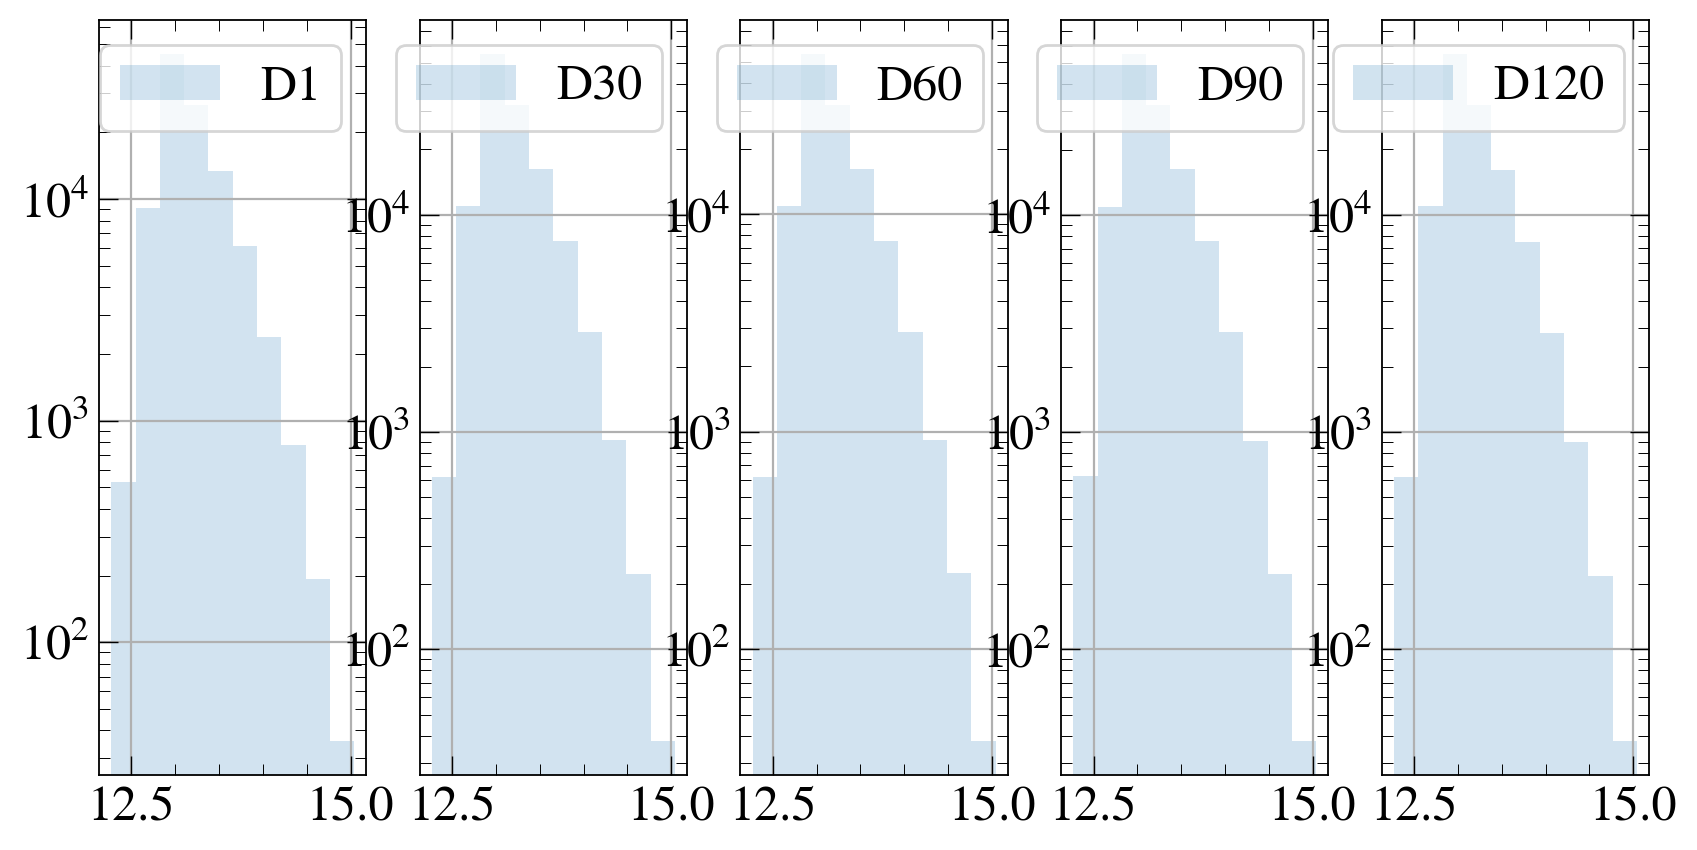

In [15]:
fig, axes = plt.subplots(1,5, figsize=(10,5))
axes[0].hist(np.log10(cluster_halo_1['baseDC2/sod_halo_mass']), alpha=0.2, label='D1')
axes[0].set_yscale('log')
axes[0].legend()
axes[1].hist(np.log10(cluster_halo_30['baseDC2/sod_halo_mass']), alpha=0.2, label='D30')
axes[1].set_yscale('log')
axes[1].legend()
axes[2].hist(np.log10(cluster_halo_60['baseDC2/sod_halo_mass']), alpha=0.2, label='D60')
axes[2].set_yscale('log')
axes[2].legend()
axes[3].hist(np.log10(cluster_halo_90['baseDC2/sod_halo_mass']), alpha=0.2, label='D90')
axes[3].set_yscale('log')
axes[3].legend()
axes[4].hist(np.log10(cluster_halo_120['baseDC2/sod_halo_mass']), alpha=0.2, label='D120')
plt.yscale('log')
plt.legend()
plt.show()

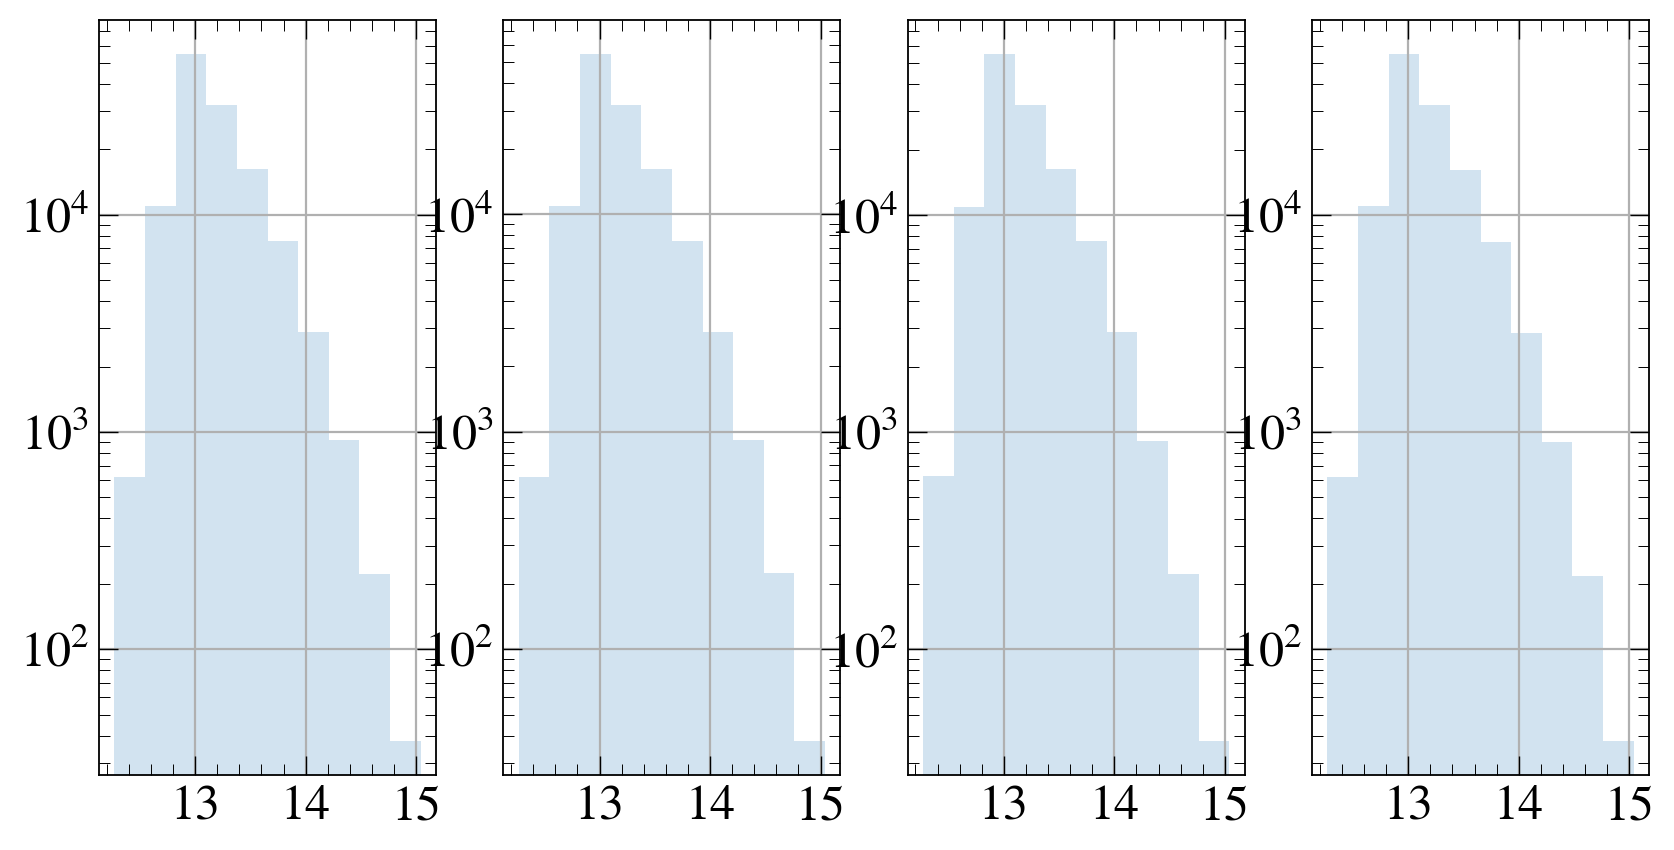

In [16]:
fig, axes = plt.subplots(1,4, figsize=(10,5))
axes[0].hist(np.log10(cluster_halo_30['mass']), alpha=0.2)
axes[0].set_yscale('log')
axes[1].hist(np.log10(cluster_halo_60['mass']), alpha=0.2)
axes[1].set_yscale('log')
axes[2].hist(np.log10(cluster_halo_90['mass']), alpha=0.2)
axes[2].set_yscale('log')
axes[3].hist(np.log10(cluster_halo_120['mass']), alpha=0.2)
plt.yscale('log')

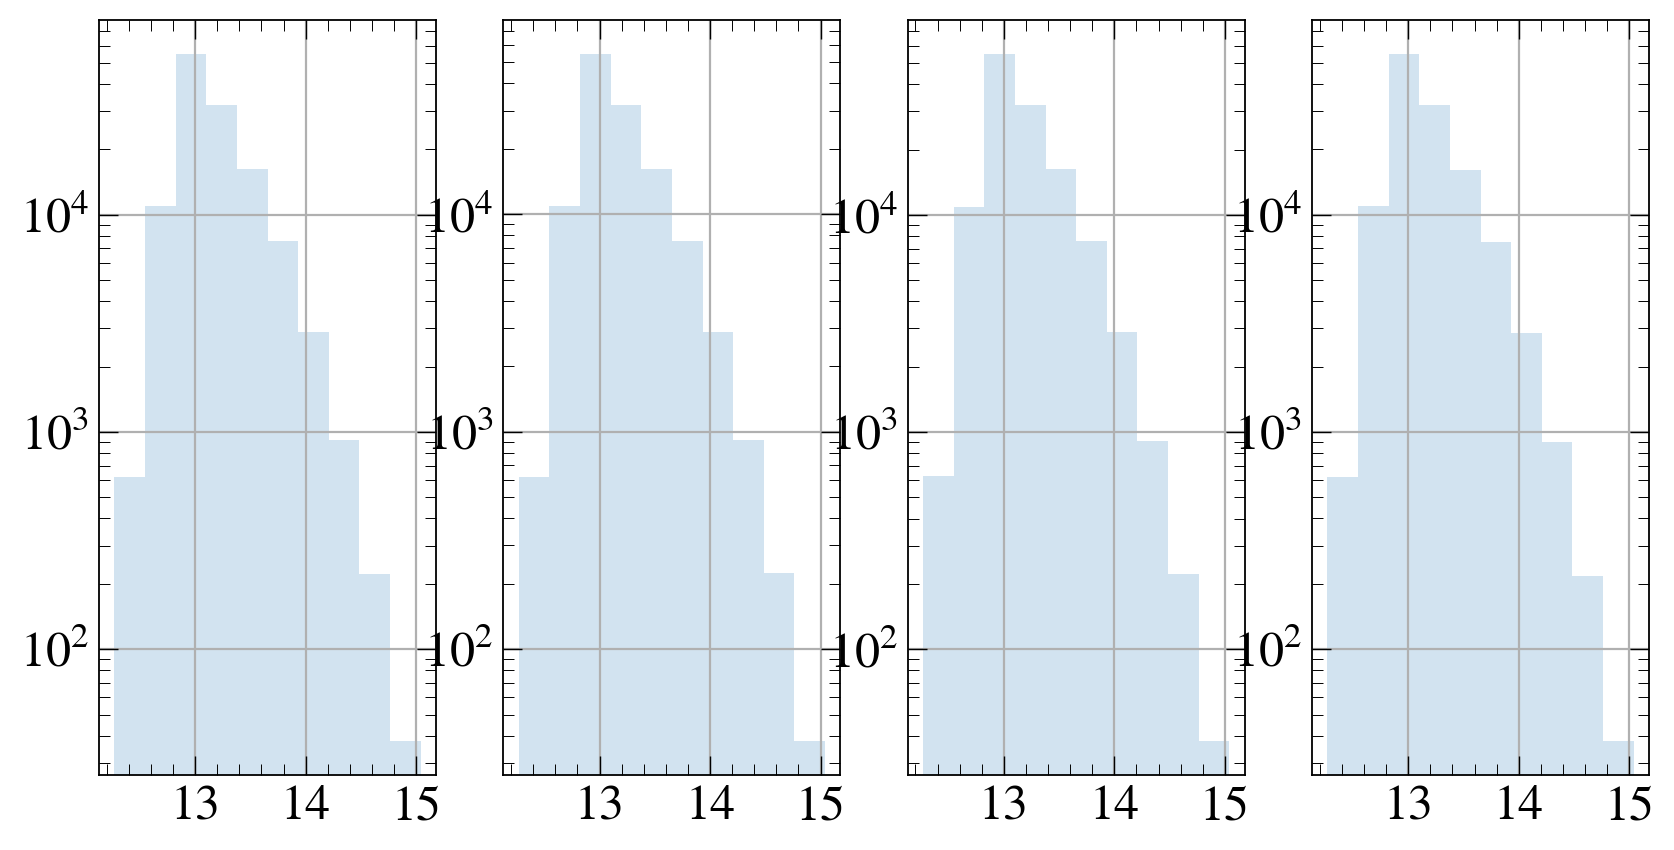

In [17]:
fig, axes = plt.subplots(1,4, figsize=(10,5))
axes[0].hist(np.log10(cluster_30['mass']), alpha=0.2)
axes[0].set_yscale('log')
axes[1].hist(np.log10(cluster_60['mass']), alpha=0.2)
axes[1].set_yscale('log')
axes[2].hist(np.log10(cluster_90['mass']), alpha=0.2)
axes[2].set_yscale('log')
axes[3].hist(np.log10(cluster_120['mass']), alpha=0.2)
plt.yscale('log')

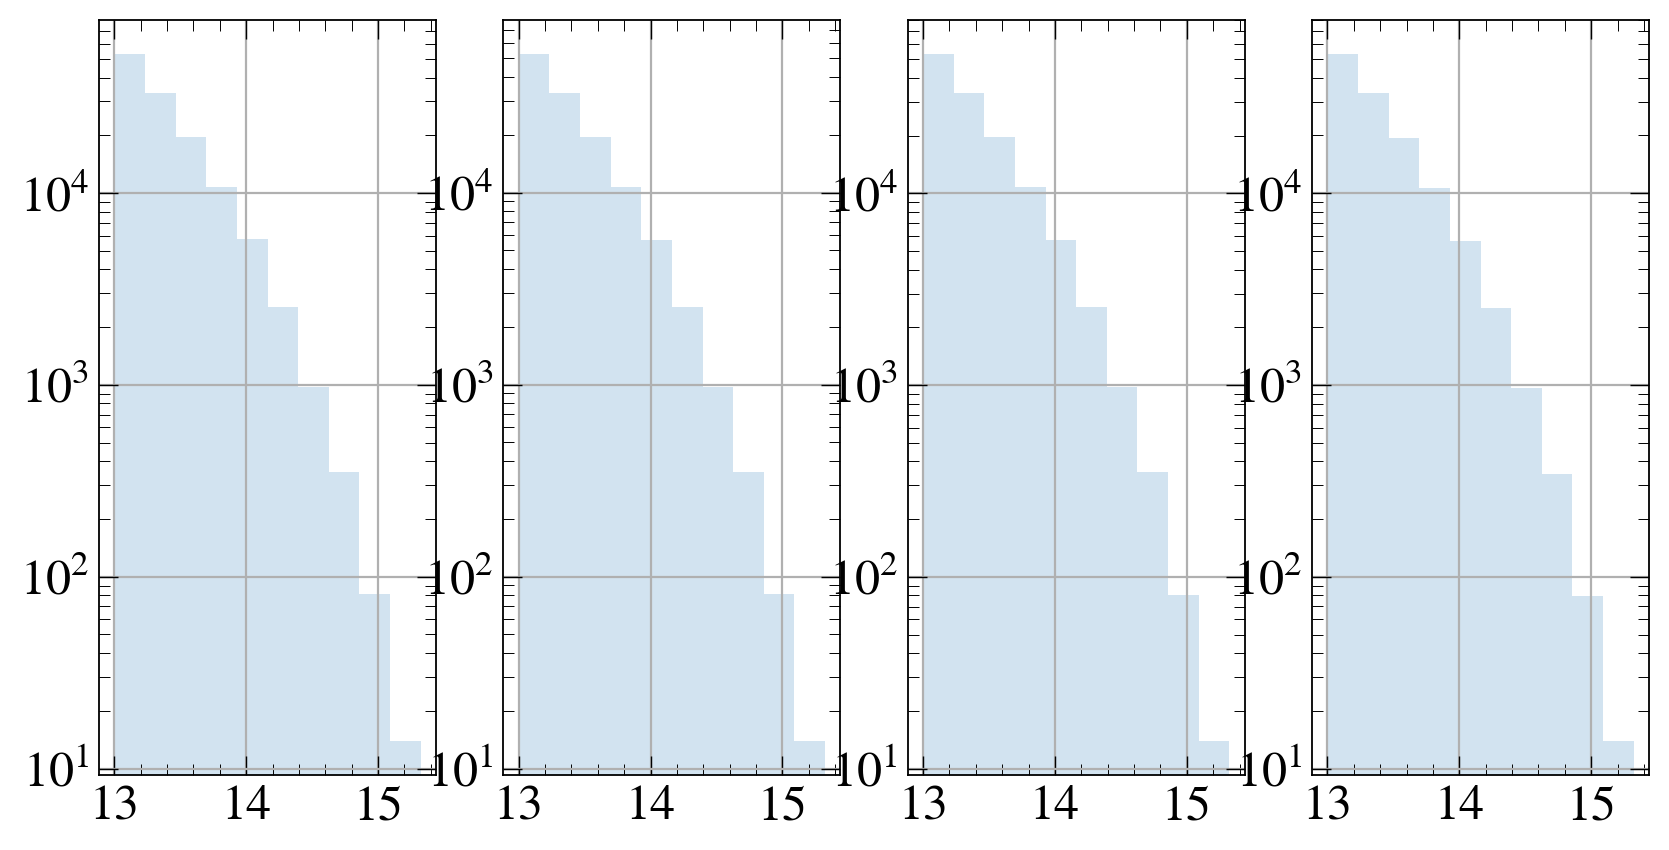

In [18]:
fig, axes = plt.subplots(1,4, figsize=(10,5))
axes[0].hist(np.log10(cluster_halo_30['halo_mass']), alpha=0.2)
axes[0].set_yscale('log')
axes[1].hist(np.log10(cluster_halo_60['halo_mass']), alpha=0.2)
axes[1].set_yscale('log')
axes[2].hist(np.log10(cluster_halo_90['halo_mass']), alpha=0.2)
axes[2].set_yscale('log')
axes[3].hist(np.log10(cluster_halo_120['halo_mass']), alpha=0.2)
plt.yscale('log')

In [19]:
cluster_halo_30[['baseDC2/sod_halo_mass', 'mass', 'halo_mass']]

,baseDC2/sod_halo_mass,mass,halo_mass
6362,7.278854e+14,7.278854e+14,2.103824e+15
43944,2.317200e+14,2.317200e+14,1.245801e+15
126204,9.082157e+14,9.082157e+14,1.403699e+15
22454,9.617305e+14,9.617305e+14,1.686824e+15
99215,7.617416e+14,7.617416e+14,1.823229e+15
...,...,...,...
87115,7.589531e+12,7.589531e+12,1.174394e+13
87116,1.422367e+13,1.422367e+13,2.254082e+13
30549,2.251727e+13,2.251727e+13,3.061818e+13
87118,1.285434e+13,1.285434e+13,2.319919e+13


In [20]:
'{:e}'.format((cluster_halo_30['baseDC2/sod_halo_mass']).max()), '{:e}'.format((cluster_halo_30['mass']).max())

('1.099301e+15', '1.099301e+15')

In [21]:
'{:e}'.format((cluster_halo_30['baseDC2/sod_halo_mass']).max()), '{:e}'.format((cluster_30['mass']).max())

('1.099301e+15', '1.099301e+15')

In [22]:
cluster_halo_30['mass']

6362      7.278854e+14
43944     2.317200e+14
126204    9.082157e+14
22454     9.617305e+14
99215     7.617416e+14
              ...     
87115     7.589531e+12
87116     1.422367e+13
30549     2.251727e+13
87118     1.285434e+13
126318    1.334590e+13
Name: mass, Length: 126319, dtype: float64

In [23]:
cluster_30[cluster_30['halo_id']==152507764373]  #333509309392

,halo_id,mass,ra,dec,redshift,rlam,lam,pixelid
71418,152507764373,1.099301e+15,0.980966,-0.271798,0.315978,1.09856,160,7764


In [24]:
sigma_ds_profile[sigma_ds_profile['halo_id']==152507764373]

,halo_id,radius,sigma,DS,baseDC2/sod_halo_mass,baseDC2/sod_halo_radius,redshift,dec,magnification,hostHaloMass,ra,halo_mass,pixel_id
44090,152507764373,"[0.13860420203163068, 0.19749218385019007, 0.3...","[1718707696459281.8, 1376610862857179.8, 66985...","[224385669515578.88, 437368286191477.94, 47496...",1.099301e+15,1.993995,0.315978,-15.5729,0.999944,1.332660e+15,56.205198,1.876986e+15,7764


In [25]:
cluster_halo_30[cluster_halo_30['halo_id']==152507764373]

,halo_id,radius,sigma,DS,baseDC2/sod_halo_mass,baseDC2/sod_halo_radius,redshift_x,dec_x,magnification,hostHaloMass,ra_x,halo_mass,pixel_id,mass,ra_y,dec_y,redshift_y,rlam,lam,pixelid
2593,152507764373,"[0.13860420203163068, 0.19749218385019007, 0.3...","[1718707696459281.8, 1376610862857179.8, 66985...","[224385669515578.88, 437368286191477.94, 47496...",1.099301e+15,1.993995,0.315978,-15.5729,0.999944,1.332660e+15,56.205198,1.876986e+15,7764,1.099301e+15,0.980966,-0.271798,0.315978,1.09856,160,7764


In [26]:
cluster_30[cluster_30['mass']==(cluster_30['mass']).max()]

,halo_id,mass,ra,dec,redshift,rlam,lam,pixelid
71418,152507764373,1.099301e+15,0.980966,-0.271798,0.315978,1.09856,160,7764


In [27]:
(cluster_halo_30.isna()).sum()

halo_id                    0
radius                     0
sigma                      0
DS                         0
baseDC2/sod_halo_mass      0
baseDC2/sod_halo_radius    0
redshift_x                 0
dec_x                      0
magnification              0
hostHaloMass               0
ra_x                       0
halo_mass                  0
pixel_id                   0
mass                       0
ra_y                       0
dec_y                      0
redshift_y                 0
rlam                       0
lam                        0
pixelid                    0
dtype: int64

In [28]:
len(sigma_ds_profile['halo_id'].unique())

2152757